## Plant Location with Non-Linear Costsz

One industry plans to install two plants, one to the west (region 1) and another to the east (region 2). It must decide also the production capacity of each plant and allocate clients with different demands to plants in order to minimize shipping costs, which depend on the distance to the selected plant. Clients can be served by facilities of both regions. The cost of installing a plant with capacity 𝑧 is 𝑓(𝑧)=1520log𝑧. The Figure below shows the distribution of clients in circles and possible plant locations as triangles.

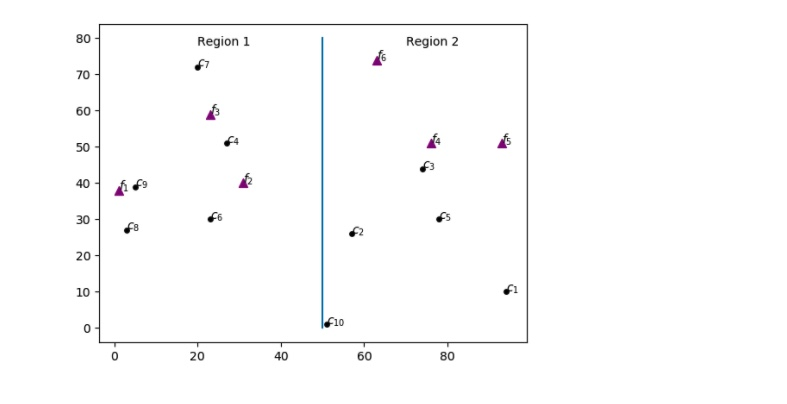

This example illustrates the use of Special Ordered Sets (SOS). We’ll use Type 1 SOS to ensure that only one of the plants in each region has a non-zero production capacity. The cost 𝑓(𝑧) of building a plant with capacity 𝑧 grows according to the non-linear function 𝑓(𝑧)=1520log𝑧. Type 2 SOS will be used to model the cost of installing each one of the plants in auxiliary variables 𝑦.

Welcome to the CBC MILP Solver 
Version: devel 
Build Date: Nov 15 2020 

Starting solution of the Linear programming problem using Primal Simplex

Coin0506I Presolve 28 (-6) rows, 96 (-12) columns and 192 (-42) elements
Clp1000I sum of infeasibilities 0.000326278 - average 1.16528e-05, 71 fixed columns
Coin0506I Presolve 4 (-24) rows, 8 (-88) columns and 11 (-181) elements
Clp0029I End of values pass after 8 iterations
Clp0000I Optimal - objective value 74461.17
Clp0000I Optimal - objective value 74461.17
Coin0511I After Postsolve, objective 74461.17, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 74461.17
Clp0000I Optimal - objective value 74461.17
Clp0000I Optimal - objective value 74461.17
Coin0511I After Postsolve, objective 74461.17, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 74461.16986 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00
Cbc3007W No integer variables - nothing to do

Starting MIP optimization
Solution wi

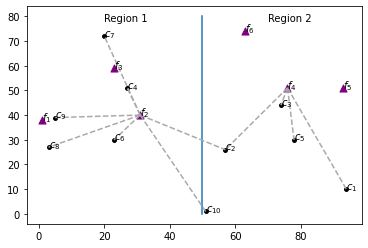

In [1]:
import matplotlib.pyplot as plt
from math import sqrt, log
from itertools import product
from mip import Model, xsum, minimize, OptimizationStatus

# possible plants
F = [1, 2, 3, 4, 5, 6]

# possible plant installation positions
pf = {1: (1, 38), 2: (31, 40), 3: (23, 59), 4: (76, 51), 5: (93, 51), 6: (63, 74)}

# maximum plant capacity
c = {1: 1955, 2: 1932, 3: 1987, 4: 1823, 5: 1718, 6: 1742}

# clients
C = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# position of clients
pc = {1: (94, 10), 2: (57, 26), 3: (74, 44), 4: (27, 51), 5: (78, 30), 6: (23, 30), 
      7: (20, 72), 8: (3, 27), 9: (5, 39), 10: (51, 1)}

# demands
d = {1: 302, 2: 273, 3: 275, 4: 266, 5: 287, 6: 296, 7: 297, 8: 310, 9: 302, 10: 309}

# plotting possible plant locations
for i, p in pf.items():
    plt.scatter((p[0]), (p[1]), marker="^", color="purple", s=50)
    plt.text((p[0]), (p[1]), "$f_%d$" % i)

# plotting location of clients
for i, p in pc.items():
    plt.scatter((p[0]), (p[1]), marker="o", color="black", s=15)
    plt.text((p[0]), (p[1]), "$c_{%d}$" % i)

plt.text((20), (78), "Region 1")
plt.text((70), (78), "Region 2")
plt.plot((50, 50), (0, 80))

dist = {(f, c): round(sqrt((pf[f][0] - pc[c][0]) ** 2 + (pf[f][1] - pc[c][1]) ** 2), 1)
        for (f, c) in product(F, C) }

m = Model()

z = {i: m.add_var(ub=c[i]) for i in F}  # plant capacity

# Type 1 SOS: only one plant per region
for r in [0, 1]:
    # set of plants in region r
    Fr = [i for i in F if r * 50 <= pf[i][0] <= 50 + r * 50]
    m.add_sos([(z[i], i - 1) for i in Fr], 1)

# amount that plant i will supply to client j
x = {(i, j): m.add_var() for (i, j) in product(F, C)}

# satisfy demand
for j in C:
    m += xsum(x[(i, j)] for i in F) == d[j]

# SOS type 2 to model installation costs for each installed plant
y = {i: m.add_var() for i in F}
for f in F:
    D = 6  # nr. of discretization points, increase for more precision
    v = [c[f] * (v / (D - 1)) for v in range(D)]  # points
    # non-linear function values for points in v
    vn = [0 if k == 0 else 1520 * log(v[k]) for k in range(D)]  
    # w variables
    w = [m.add_var() for v in range(D)]
    m += xsum(w) == 1  # convexification
    # link to z vars
    m += z[f] == xsum(v[k] * w[k] for k in range(D))
    # link to y vars associated with non-linear cost
    m += y[f] == xsum(vn[k] * w[k] for k in range(D))
    m.add_sos([(w[k], v[k]) for k in range(D)], 2)

# plant capacity
for i in F:
    m += z[i] >= xsum(x[(i, j)] for j in C)

# objective function
m.objective = minimize(
    xsum(dist[i, j] * x[i, j] for (i, j) in product(F, C)) + xsum(y[i] for i in F) )

m.optimize()

plt.savefig("location.pdf")

if m.num_solutions:
    print("Solution with cost {} found.".format(m.objective_value))
    print("Facilities capacities: {} ".format([z[f].x for f in F]))
    print("Facilities cost: {}".format([y[f].x for f in F]))

    # plotting allocations
    for (i, j) in [(i, j) for (i, j) in product(F, C) if x[(i, j)].x >= 1e-6]:
        plt.plot(
            (pf[i][0], pc[j][0]), (pf[i][1], pc[j][1]), linestyle="--", color="darkgray"
        )

    plt.savefig("location-sol.pdf")